![](https://i.ibb.co/yQ3D64X/face.jpg)

# Customer churn



*It is necessary to predict whether the client will leave the bank in the near future or not.
We have been provided with historical data on customer behavior and termination of agreements with the bank*


## General information about data in operation and preinspection

### Importing required libraries

In [1]:
!pip install catboost

In [2]:
!gdown --id 1cjqAvITkVdlNyIEDjPSO1wHuTGwNa616

Downloading...
From: https://drive.google.com/uc?id=1cjqAvITkVdlNyIEDjPSO1wHuTGwNa616
To: /content/Churn_Modelling.csv
100% 685k/685k [00:00<00:00, 21.6MB/s]


In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, accuracy_score
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import Pool, cv
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")



### Exploring Data Set

In [4]:
df = pd.read_csv('/content/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Features: 

- `RowNumber` - the index of the row in the data
- `CustomerId` - unique customer identifier
- `Surname` - surname
- `CreditScore` - credit rating
- `Geography` - country of residence
- `Gender` - gender
- `Age` - age
- `Tenure` - how many years a person has been a client of the bank
- `Balance` - account balance
- `NumOfProducts` - the number of bank products used by the client
- `HasCrCard` - availability of a credit card
- `IsActiveMember` - client activity
- `EstimatedSalary` - estimated salary

Target column:

- `Exited` - the fact of the client's departure

For our convenience, we will lower the name of the columns and bring them to the serpentine register

In [5]:
df.columns = df.columns.str.lower()
df.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

In [6]:
df.columns = ['row_number', 'customer_id', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_crcard',
       'isactive_member', 'estimated_salary', 'exited']
df.columns

Index(['row_number', 'customer_id', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_crcard',
       'isactive_member', 'estimated_salary', 'exited'],
      dtype='object')

Let's see general information about data in work

In [7]:
print(df.shape)
df.info()

(10000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   creditscore       10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  int64  
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_crcard        10000 non-null  int64  
 11  isactive_member   10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


We have no NaN in our set


Let's take a look at the data types in our dataframe separately:

In [8]:
df.dtypes

row_number            int64
customer_id           int64
surname              object
creditscore           int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_crcard            int64
isactive_member       int64
estimated_salary    float64
exited                int64
dtype: object

we need `tenure` to be integre

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
row_number,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
customer_id,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
creditscore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
num_of_products,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
has_crcard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
isactive_member,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
estimated_salary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


At first glance, we do not observe anomalies in the data, significant outliers. For example, by age, the minimum age is 18 - the maximum is 92, which may be true.

Let's see the target column `exited`

In [10]:
df['exited'].value_counts().to_frame()

,exited
0,7963
1,2037


In [11]:
print('Percentage of positive marks: {:.2%}'.format(df['exited'].mean()))

Percentage of positive marks: 20.37%


There is a class imbalance. We will train the model on the initial data, then we will try to overcome the imbalance and train again. Let's see the results later.


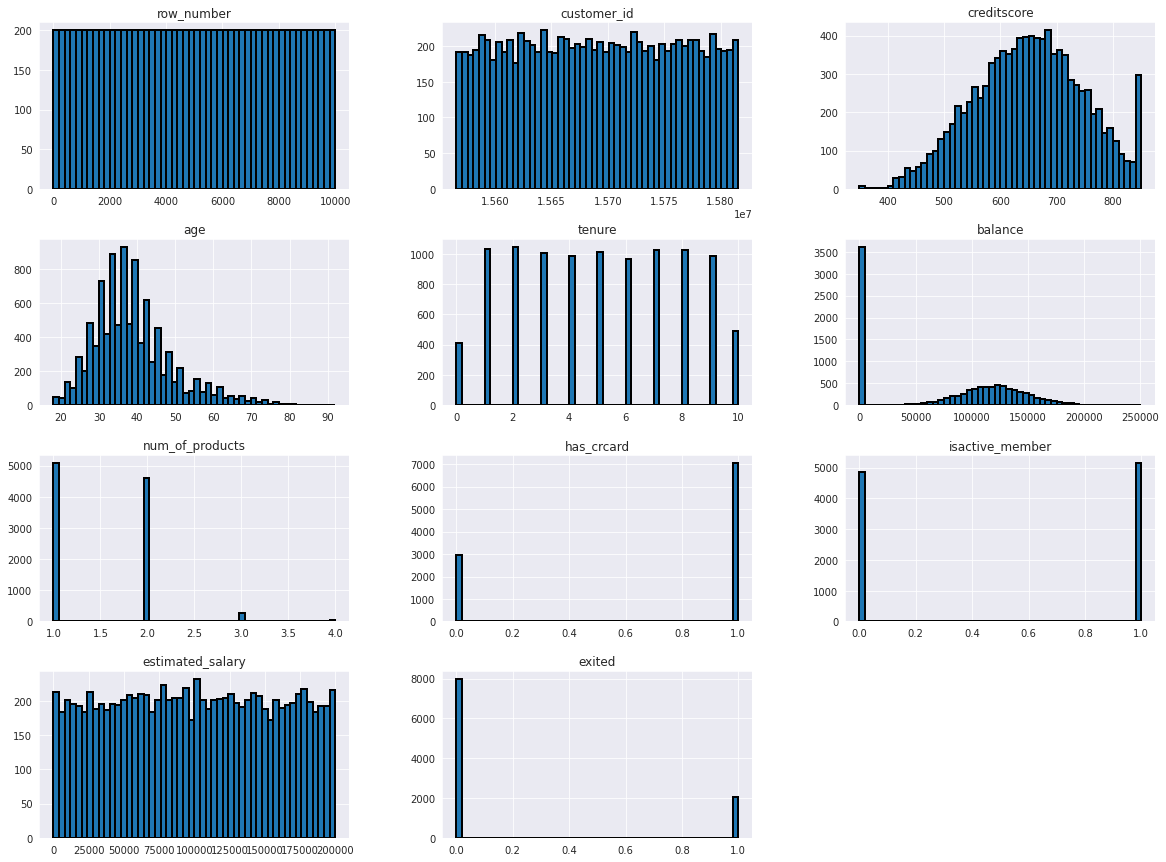

In [12]:
df.hist(bins=50, figsize=(20,15), edgecolor='black', linewidth=2)
plt.show()

In the process of feature engeneering for our model, it will be possible to delete three columns - `customer_id`,` row_number` and `surname`, which do not carry the payload in our case

In [13]:
df.duplicated().sum()

0

### Conclusion

Customer churn is the loss of customers, expressed in the absence of purchases or payments over a period of time. Churn rate is extremely important for companies with a subscription and transactional business model that means recurring payments to the company.

We've previewed our dataset:

- no duplicates found, no need to delete lines
- in the process of preparing features for analysis - remove the columns `customer_id`,` row_number` and `surname`


We can start preparing the features

## Research of task

We are faced with the task of classification - it is necessary to determine whether the client will leave in the near future or not. Thus, to achieve the goals of this task, I propose to use the algorithms of Logistic Regression, Random Forest and Catboost.

To evaluate the models, we will use the F1 measure (`F1 score`) (let us apply the good values is > 0.59)

To evaluate the final model, we use the ROC curve with its area (`ROC-AUC`).

As we found out, we have an imbalance of classes, accuracy does not suit us.

### Features engeneering

In [14]:
df.head()

,row_number,customer_id,surname,creditscore,geography,gender,age,tenure,balance,num_of_products,has_crcard,isactive_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Let's remove unnecessary features and form a new date set so as not to overwrite variables

In [15]:
data = df.drop(['row_number', 'customer_id', 'surname'], axis=1).copy()
data.head()

,creditscore,geography,gender,age,tenure,balance,num_of_products,has_crcard,isactive_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### One-hot Encoding

The categorical features `geography` and` gender` must be converted to numerical ones using the direct coding technique, or display (English One-Hot Encoding, OHE). We need quantitative features to be more accurate

In [16]:
data['geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

In [17]:
data['gender'].value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

In [18]:
# OHE of features
gender_ohe = pd.get_dummies(df["gender"], drop_first=True)
country_ohe = pd.get_dummies(df["geography"], drop_first=True)

# delete catfeatures
data.drop(["gender", "geography"], axis=1, inplace=True)

#concat new sets
df_ohe = pd.concat([data, gender_ohe, country_ohe], axis=1)

df_ohe.head()

,creditscore,age,tenure,balance,num_of_products,has_crcard,isactive_member,estimated_salary,exited,Male,Germany,Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1


In [19]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   creditscore       10000 non-null  int64  
 1   age               10000 non-null  int64  
 2   tenure            10000 non-null  int64  
 3   balance           10000 non-null  float64
 4   num_of_products   10000 non-null  int64  
 5   has_crcard        10000 non-null  int64  
 6   isactive_member   10000 non-null  int64  
 7   estimated_salary  10000 non-null  float64
 8   exited            10000 non-null  int64  
 9   Male              10000 non-null  uint8  
 10  Germany           10000 non-null  uint8  
 11  Spain             10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


Columns were coded. 

It is also necessary to standardize the characteristics, since the quantitative values ​​vary greatly. We will not apply standardization to the columns `tenure`,` num_of_products`, `has_crcard`,` isactive_member` and to the target with transformed categorical

### Split data set

We have prepared features. Now we will divide our samples into training, validation for the selection of hyperparameters and test, on which we will test our model. We will not touch the test sample to the end, we will work out the best model on it

In [20]:
def split_data(data, target_column):
    return data.drop(columns=[target_column], axis=1), data[target_column]

In [21]:
features, target = split_data(df_ohe,'exited')

We get a validation sample of 20% and divide the remaining 80% again to obtain a test sample. We will conduct training on 60% of the data

In [22]:
features_df, features_valid, target_df, target_valid = ( 
                                train_test_split(
                                features, target, test_size=0.20, random_state=42)
)


In [23]:
features_train, features_test, target_train, target_test = ( 
                                train_test_split(
                                features_df, target_df, test_size=0.25, random_state=42)
)


In [24]:
print('Objects of train:', len(features_train))
print('Objects of valid:', len(features_valid))
print('Objects of test:', len(features_test))
print('Sum of objects:', len(features_train) + len(features_test) + len(features_test))
print()
print('Objects of original set (check sum):', len(df_ohe))

Objects of train: 6000
Objects of valid: 2000
Objects of test: 2000
Sum of objects: 10000

Objects of original set (check sum): 10000


The sample was divided, we can proceed to trial training of the models. In our task, there is a strong class imbalance, which has a bad effect on training the model. Let's look at the results, we will evaluate the model by the F1 measure - it is a good candidate for a formal metric for assessing the quality of the classifier. It reduces to one number two other fundamental metrics: `precision` and` recall`

### Scaling

Scaling features across the entire dataset can lead to a data leak. You only need to train the scaler on the train.

We will train and then apply to our samples

In [25]:
numeric = ['creditscore', 'age', 'balance', 'estimated_salary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
pd.options.mode.chained_assignment = None
features_train[numeric] = scaler.transform(features_train[numeric])
features_train.head()

,creditscore,age,tenure,balance,num_of_products,has_crcard,isactive_member,estimated_salary,Male,Germany,Spain
8588,0.626553,-0.948125,7,0.026803,1,1,0,0.389943,0,0,1
3178,-1.143262,0.006684,4,0.538874,2,1,1,-1.026089,0,0,0
5200,-1.455583,0.293126,9,0.283178,2,1,0,-1.486725,1,1,0
8889,-0.747657,0.006684,9,0.833254,1,1,0,-0.246001,0,0,0
5789,0.387107,1.534377,1,0.000856,1,1,0,-1.006993,0,1,0


Let's apply a trained scaller to the validation set

In [26]:
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_valid.head()

,creditscore,age,tenure,balance,num_of_products,has_crcard,isactive_member,estimated_salary,Male,Germany,Spain
6252,-0.581086,-0.661682,3,0.327195,2,0,0,-1.017034,1,1,0
4684,-0.299998,0.388607,1,-1.218934,2,1,1,0.805136,1,0,0
1731,-0.529032,0.484088,4,-1.218934,2,1,0,-0.724818,0,0,1
4742,-1.518047,1.916301,8,0.686002,2,1,1,1.228495,1,1,0
4521,-0.955870,-1.139087,7,0.779430,1,1,1,0.252697,0,0,1


Let's apply a trained scaller to the test set

In [27]:
features_test[numeric] = scaler.transform(features_test[numeric])
features_test.head()

,creditscore,age,tenure,balance,num_of_products,has_crcard,isactive_member,estimated_salary,Male,Germany,Spain
3188,1.553103,-0.661682,4,-0.017150,1,1,1,-1.084803,0,0,0
8293,1.188729,-1.043606,4,0.231074,1,0,1,-1.368802,0,1,0
1710,1.834191,-1.043606,8,0.935642,1,1,0,-0.362538,1,0,1
7510,1.521871,-0.279759,1,-1.218934,2,1,1,1.025781,1,0,0
1461,-0.424926,-0.470721,4,-1.218934,2,1,0,1.233214,1,0,1


### Trial training of models without considering class imbalance

#### Logistic regression

Let's start with basic logistic regression. We do not indicate the weight of the classes

In [28]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.29158878504672897



Poor enough indicator. Let's try to specify `class_weight = 'balanced' '

In [29]:
model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5066904549509367


Better now. At this stage, we will not select the hyperparameters, we will move on to the next algorithm

#### Random forest

In [30]:
model = RandomForestClassifier(random_state=42, n_estimators=10)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5305466237942122


The random forest did better in terms of class imbalance. Similar to logistic regression, let's try setting the `class_weight` parameter

In [31]:
model = RandomForestClassifier(random_state=42, n_estimators=10, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5016393442622952


The indicator has worsened. also now we will not change the hyperparameters, we will return to this after we fix the imbalance problem

#### Catboost

In [32]:
model = CatBoostClassifier(verbose=100, random_state=42)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

Learning rate set to 0.022141
0:	learn: 0.6745639	total: 51.8ms	remaining: 51.8s
100:	learn: 0.3380760	total: 419ms	remaining: 3.73s
200:	learn: 0.3124092	total: 790ms	remaining: 3.14s
300:	learn: 0.2985487	total: 1.15s	remaining: 2.67s
400:	learn: 0.2858427	total: 1.5s	remaining: 2.24s
500:	learn: 0.2734469	total: 1.85s	remaining: 1.85s
600:	learn: 0.2629092	total: 2.21s	remaining: 1.47s
700:	learn: 0.2533047	total: 2.56s	remaining: 1.09s
800:	learn: 0.2443376	total: 2.94s	remaining: 731ms
900:	learn: 0.2356826	total: 3.29s	remaining: 362ms
999:	learn: 0.2274841	total: 3.65s	remaining: 0us
F1: 0.5950920245398773


F1 is a fairly high measure, let's look at the results after we select the hyperparameters and test the model on a test sample

### Conclusion

We are faced with the task of classification. In order to improve the forecasting results and facilitate the training of the model, we have transformed the data:

- removed unnecessary features - such as surname, customer id and line number
- carried out coding of categorical variables
- carried out scaling of quantitative variables
- divided the samples in a ratio of 60%: 20%: 20% - training, validation for the selection of hyperparameters and model verification, test - for the final model verification and evaluation

We tried to train the models on objects with class imbalance. Now let's try to get rid of this problem, select the model hyperparameters.

## Dealing with imbalances and improving models

Classes are not represented in the same way in our problem, let's look again:

In [33]:
df['exited'].value_counts().to_frame()

,exited
0,7963
1,2037


Let's try to solve this problem in three ways. We will choose the best one and use it to improve our model.

### Upsampling

To do this, let's use a function that performs the following transformations:

- divide the training sample into negative and positive objects
- copy positive objects several times
- taking into account the received data, we will create a new training sample
- shuffle the data 

In [34]:
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled = shuffle(features_upsampled, random_state=12345)
    target_upsampled = shuffle(target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

    
    
features_upsampled, target_upsampled = upsample(features_train, target_train, 5)

print(features_upsampled.shape)
print(target_upsampled.shape)

(10924, 11)
(10924,)


#### Logistic regression

In [35]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.46636085626911317


We observe a slight increase in the metric, close to the one we got by specifying the `class_weight` parameter

#### Random Forest

In [36]:
model = RandomForestClassifier(random_state=42, n_estimators=10)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5433854907539117


There is also an improvement here

#### Catboost

In [37]:
model = CatBoostClassifier(verbose=100, random_state=42)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

Learning rate set to 0.028597
0:	learn: 0.6778999	total: 6.98ms	remaining: 6.97s
100:	learn: 0.4288946	total: 710ms	remaining: 6.32s
200:	learn: 0.3911498	total: 1.39s	remaining: 5.53s
300:	learn: 0.3633346	total: 2.04s	remaining: 4.73s
400:	learn: 0.3380128	total: 2.69s	remaining: 4.01s
500:	learn: 0.3152383	total: 3.33s	remaining: 3.31s
600:	learn: 0.2957510	total: 3.96s	remaining: 2.63s
700:	learn: 0.2779148	total: 4.63s	remaining: 1.98s
800:	learn: 0.2619604	total: 5.28s	remaining: 1.31s
900:	learn: 0.2474926	total: 5.94s	remaining: 653ms
999:	learn: 0.2337266	total: 6.56s	remaining: 0us
F1: 0.6117647058823529


Catboost Shows Better Results Again On Validation Set

Let's try another way - decreasing the sample

### Downsampling

To do this, let's use a function that performs the following transformations:

- divide the training sample into negative and positive objects
- randomly discard some of the negative objects
- taking into account the received data, we will create a new training sample
- shuffle the data

In [38]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_sample = features_zeros.sample(frac=0.1, random_state=12345)
    target_sample = target_zeros.sample(frac=0.1, random_state=12345)
    
    features_downsampled = pd.concat([features_sample] + [features_ones])
    target_downsampled = pd.concat([target_sample] + [target_ones])
    
    features_downsampled = shuffle(features_downsampled, random_state=12345)
    target_downsampled = shuffle(target_downsampled, random_state=12345)
    

    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

print(features_downsampled.shape)
print(target_downsampled.shape)

(1708, 11)
(1708,)



#### Logistic regression

In [39]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.3993471164309031


#### Random forest

In [40]:
model = RandomForestClassifier(random_state=42, n_estimators=10)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.4709851551956815


#### Catboost

In [41]:
model = CatBoostClassifier(verbose=100, random_state=42)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))



Learning rate set to 0.012948
0:	learn: 0.6839809	total: 2.16ms	remaining: 2.16s
100:	learn: 0.4169559	total: 208ms	remaining: 1.85s
200:	learn: 0.3696090	total: 402ms	remaining: 1.6s
300:	learn: 0.3412463	total: 597ms	remaining: 1.39s
400:	learn: 0.3209387	total: 805ms	remaining: 1.2s
500:	learn: 0.3017706	total: 1s	remaining: 1s
600:	learn: 0.2846238	total: 1.21s	remaining: 803ms
700:	learn: 0.2681526	total: 1.4s	remaining: 598ms
800:	learn: 0.2526159	total: 1.6s	remaining: 397ms
900:	learn: 0.2378979	total: 1.79s	remaining: 197ms
999:	learn: 0.2235077	total: 1.99s	remaining: 0us
F1: 0.47213114754098356


`Downsampling` shows worse results than` upsampling` for all three algorithms.

Let's try changing the threshold and see what the metrics will be - this time we'll turn to `recall` and` precision`

### Change threshold

For convenience, we will translate the proximity to the classes into the probability of classes (we have two classes - 0 and 1). The probability of class "1" is enough for us. By default it is equal to 0.5 - let's try different parameters, for example, up to 0.95

#### Logistic regression

Threshold = 0.00 | Precision = 0.197, Recall = 1.000 | F1-score = 0.328
Threshold = 0.05 | Precision = 0.213, Recall = 0.982 | F1-score = 0.350
Threshold = 0.10 | Precision = 0.258, Recall = 0.924 | F1-score = 0.404
Threshold = 0.15 | Precision = 0.308, Recall = 0.832 | F1-score = 0.450
Threshold = 0.20 | Precision = 0.375, Recall = 0.730 | F1-score = 0.496
Threshold = 0.25 | Precision = 0.418, Recall = 0.618 | F1-score = 0.499
Threshold = 0.30 | Precision = 0.482, Recall = 0.519 | F1-score = 0.500
Threshold = 0.35 | Precision = 0.517, Recall = 0.433 | F1-score = 0.471
Threshold = 0.40 | Precision = 0.542, Recall = 0.331 | F1-score = 0.411
Threshold = 0.45 | Precision = 0.543, Recall = 0.254 | F1-score = 0.347
Threshold = 0.50 | Precision = 0.549, Recall = 0.198 | F1-score = 0.292
Threshold = 0.55 | Precision = 0.632, Recall = 0.153 | F1-score = 0.246
Threshold = 0.60 | Precision = 0.657, Recall = 0.117 | F1-score = 0.199
Threshold = 0.65 | Precision = 0.609, Recall = 0.071 | F1-score 

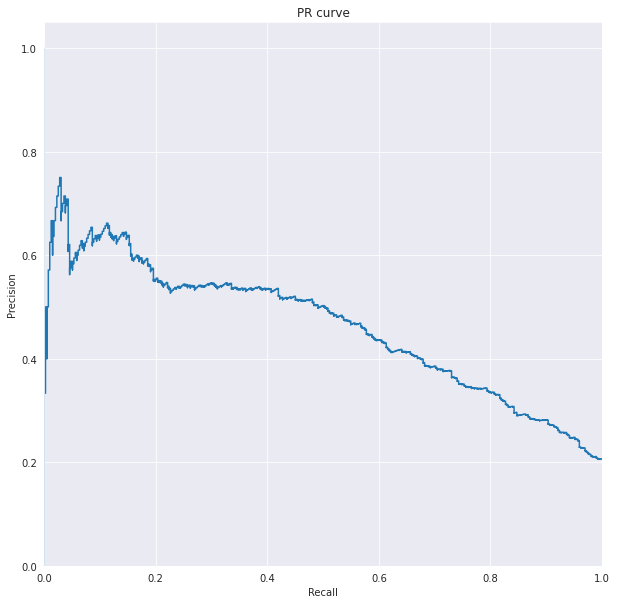

In [42]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    print("Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f} | F1-score = {:.3f}".format(
        threshold, precision, recall, f1))

precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])    
plt.figure(figsize=(10, 10))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve')
plt.show() 

For a threshold of 0, the completeness is 1 - all answers are positive. At a threshold of 0.85, the model stops giving correct answers. The highest F1 value is observed with a threshold of 0.25

#### Random forest

Threshold = 0.00 | Precision = 0.276, Recall = 0.903 | F1-score = 0.423
Threshold = 0.05 | Precision = 0.276, Recall = 0.903 | F1-score = 0.423
Threshold = 0.10 | Precision = 0.369, Recall = 0.817 | F1-score = 0.509
Threshold = 0.15 | Precision = 0.369, Recall = 0.817 | F1-score = 0.509
Threshold = 0.20 | Precision = 0.461, Recall = 0.715 | F1-score = 0.560
Threshold = 0.25 | Precision = 0.461, Recall = 0.715 | F1-score = 0.560
Threshold = 0.30 | Precision = 0.554, Recall = 0.613 | F1-score = 0.582
Threshold = 0.35 | Precision = 0.554, Recall = 0.613 | F1-score = 0.582
Threshold = 0.40 | Precision = 0.629, Recall = 0.496 | F1-score = 0.555
Threshold = 0.45 | Precision = 0.629, Recall = 0.496 | F1-score = 0.555
Threshold = 0.50 | Precision = 0.721, Recall = 0.420 | F1-score = 0.531
Threshold = 0.55 | Precision = 0.721, Recall = 0.420 | F1-score = 0.531
Threshold = 0.60 | Precision = 0.775, Recall = 0.333 | F1-score = 0.466
Threshold = 0.65 | Precision = 0.775, Recall = 0.333 | F1-score 

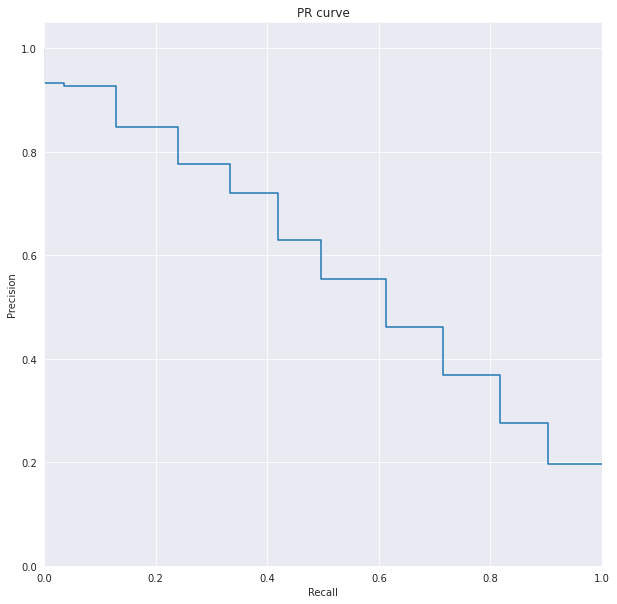

In [43]:
model = RandomForestClassifier(random_state=42, n_estimators=10)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    print("Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f} | F1-score = {:.3f}".format(
        threshold, precision, recall, f1))

precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])    
plt.figure(figsize=(10, 10))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve')
plt.show() 

The highest indicator is reached at a threshold of 0.2

Let's choose upsampling increasing the sample. On it we will train our models and select the hyperparameters. We will not change the threshold or reduce the sample

### Train Models and Tuning Hyperparameters

We will train the model on an enlarged sample, check the parameters on a validation sample and evaluate it by the F1-measure, we will not use cross-validation for logistic regression and a random forest.

The parameters will be selected through `GridSearchCV`. loop and enumeration will not be used

#### Logistic regression

In [44]:
par_grid_logist = {
                   'intercept_scaling': [0.5, 1.0, 1.5],
                   'class_weight': [None, 'balanced'],
                   'C': [0.5, 1, 1.5]
                   }
model = LogisticRegression(solver='liblinear',random_state=42)

grid_search = GridSearchCV(model, par_grid_logist, cv=5,
                           scoring='f1')
grid_search.fit(features_upsampled, target_upsampled)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.5, 1, 1.5], 'class_weight': [None, 'balanced'],
                         'intercept_scaling': [0.5, 1.0, 1.5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [45]:
grid_search.best_params_

{'C': 1.5, 'class_weight': None, 'intercept_scaling': 0.5}

Let's apply our parameters and see the result:

In [46]:
model_lreg = LogisticRegression(C=1.5, class_weight=None, intercept_scaling=0.5,
                                solver='liblinear', random_state=42
)
model_lreg.fit(features_upsampled, target_upsampled)
predicted_valid = model_lreg.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))


F1: 0.4670750382848391


Below the threshold of 0.59, let's see how the model will behave during testing

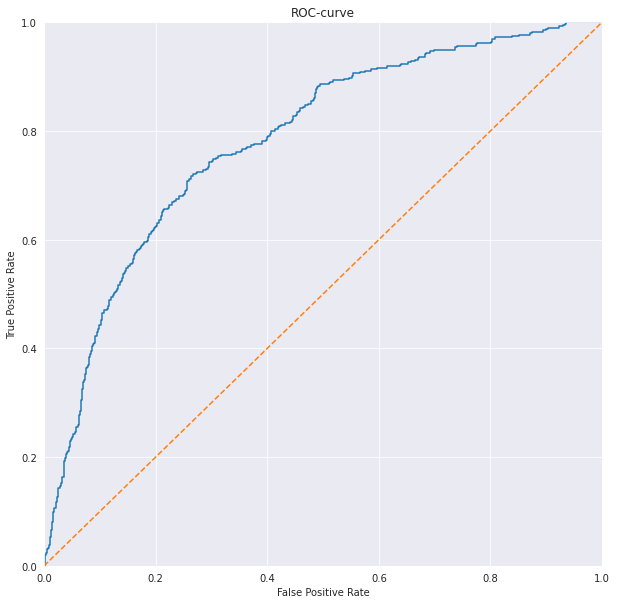

AUC: 0.7818925154104734


In [47]:
probabilities_valid = model_lreg.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()

auc_roc = roc_auc_score (target_valid, probabilities_one_valid)

print("AUC:", auc_roc)

AUC greater than 0.5, our model is better than random

#### Random forest

In [48]:
par_grid_ensemble = {'n_estimators': [3, 10, 30],
                     'criterion': ['gini', 'entropy'],
                     'min_samples_split': range(5, 15)
                    }
model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(model, par_grid_ensemble, cv=5,
                           scoring='accuracy'
                          )
grid_search.fit(features_upsampled, target_upsampled)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [49]:
grid_search.best_params_

{'criterion': 'gini', 'min_samples_split': 5, 'n_estimators': 30}

In [50]:
model_rfc = RandomForestClassifier(random_state=42, criterion='gini', 
                               min_samples_split=5, n_estimators=30
                              )
model_rfc.fit(features_upsampled, target_upsampled)
predicted_valid = model_rfc.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5933774834437087


Above the threshold of 0.59 on the validation set. Let's try on a sample test and see how the model behaves on unfamiliar data

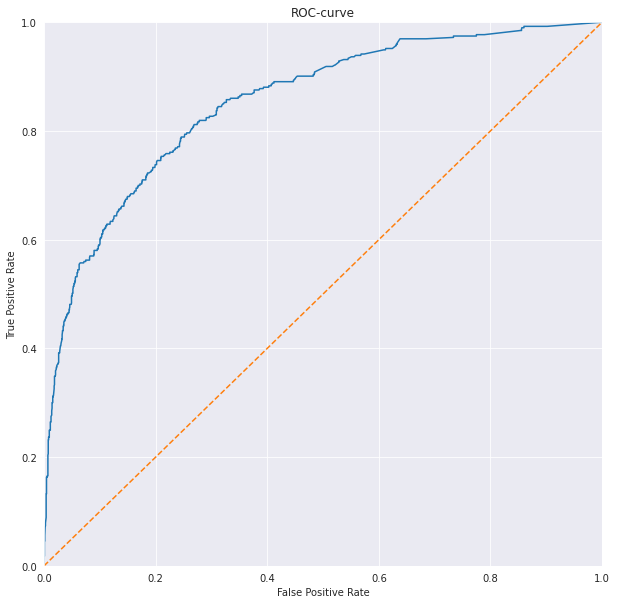

AUC: 0.8522771715981766


In [51]:
probabilities_valid = model_rfc.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

auc_roc = roc_auc_score (target_valid, probabilities_one_valid)

print("AUC:", auc_roc)

The AUC also tells us that the model is better, random, and better than logistic regression.

#### Catboost (bonus)

Let's try to configure Catboost using cross-validation. We will get the basic model, we will check it by the F1-score. Excluding class imbalance

In [52]:
model_cat = CatBoostClassifier(
                           custom_loss=['F1'],
                           random_seed=42,
                           logging_level='Silent'
)

In [53]:
model_cat.fit(
          features_train, target_train,
          eval_set=(features_valid, target_valid)

)

Get the grid of parameters and cross-validate using the built-in Pool function

In [54]:
cv_params = model_cat.get_params()
cv_params.update({
                 'loss_function': 'Logloss'
})
cv_data = cv(
             Pool(features_train, target_train),
             cv_params
)

In [55]:
print('F1-score: {}'.format(np.max(cv_data['test-F1-mean'])))

F1-score: 0.5970831232950118


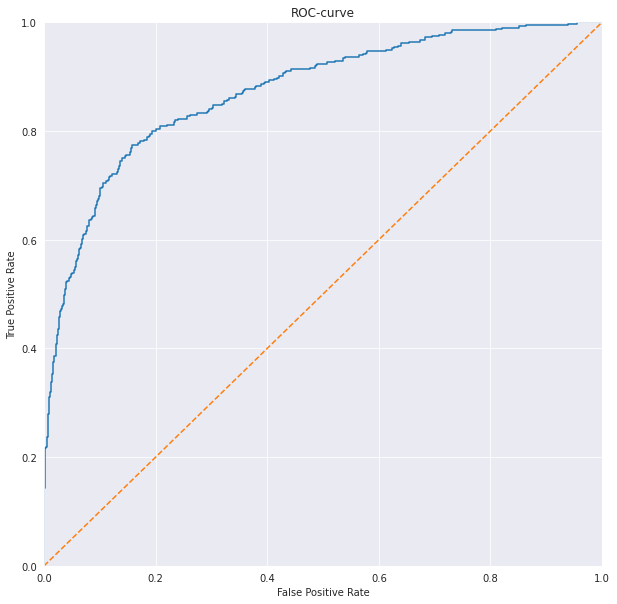

AUC: 0.8726199467659778


In [56]:
probabilities_valid = model_cat.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

auc_roc = roc_auc_score (target_valid, probabilities_one_valid)

print("AUC:", auc_roc)

We got a very good result, let's see how the model will behave on the test set. Model is better than random

## Model testing and validation

In [57]:
# collect indicators in lists

table_of_model = []
table_of_prec = []
table_of_acc = []

### Testing Models

#### Logistic regression

In [58]:
predictions_test = model_lreg.predict(features_test)
test_f1 = f1_score(target_test, predictions_test)
test_acc = accuracy_score(target_test, predictions_test)

print("Accuracy")
print("Test set:", test_acc)
print("F1-мера")
print("Test set:", test_f1)

table_of_acc.append(round(test_acc, 2))
table_of_prec.append(round(test_f1, 2))
table_of_model.append('LogisticRegression')

Accuracy
Test set: 0.668
F1-мера
Test set: 0.5044776119402985


#### Random forest

In [59]:
predictions_test = model_rfc.predict(features_test)
test_f1 = f1_score(target_test, predictions_test)
test_acc = accuracy_score(target_test, predictions_test)

print("Accuracy")
print("Test set:", test_acc)
print("F1-мера")
print("Test set:", test_f1)

table_of_acc.append(round(test_acc, 2))
table_of_prec.append(round(test_f1, 2))
table_of_model.append('RandomForestClassifier')

Accuracy
Test set: 0.8475
F1-мера
Test set: 0.6074646074646074


In [60]:
model_rfc.feature_importances_

array([0.13322635, 0.25047014, 0.08095032, 0.14346871, 0.13229459,
       0.01696499, 0.03393928, 0.14376307, 0.0206356 , 0.02899979,
       0.01528717])

In [61]:
features_test.columns

Index(['creditscore', 'age', 'tenure', 'balance', 'num_of_products',
       'has_crcard', 'isactive_member', 'estimated_salary', 'Male', 'Germany',
       'Spain'],
      dtype='object')

In [62]:
fi = pd.DataFrame({'name':features_test.columns,'fi':model_rfc.feature_importances_})
fi.sort_values('fi',ascending=False)

,name,fi
1,age,0.250470
7,estimated_salary,0.143763
3,balance,0.143469
0,creditscore,0.133226
4,num_of_products,0.132295
2,tenure,0.080950
6,isactive_member,0.033939
9,Germany,0.029000
8,Male,0.020636
5,has_crcard,0.016965


#### Catboost

In [63]:
predictions = model_cat.predict(features_test)
test_f1 = f1_score(target_test, predictions_test)
test_acc = accuracy_score(target_test, predictions_test)

print("Accuracy")
print("Test set:", test_acc)
print("F1-мера")
print("Test set:", test_f1)

table_of_acc.append(round(test_acc, 2))
table_of_prec.append(round(test_f1, 2))
table_of_model.append('Catboost')

Accuracy
Test set: 0.8475
F1-мера
Test set: 0.6074646074646074


In [64]:
model_cat.feature_importances_

array([ 5.65998167, 22.16257245,  5.03798166, 12.54538519, 28.5658523 ,
        1.20635625,  7.73938377,  4.84226016,  3.33760066,  7.36960639,
        1.5330195 ])

In [65]:
fi_cat = pd.DataFrame({'name':features_test.columns,'fi_cat':model_cat.feature_importances_})
fi_cat.sort_values('fi_cat',ascending=False)

,name,fi_cat
4,num_of_products,28.565852
1,age,22.162572
3,balance,12.545385
6,isactive_member,7.739384
9,Germany,7.369606
0,creditscore,5.659982
2,tenure,5.037982
7,estimated_salary,4.842260
8,Male,3.337601
10,Spain,1.533019


#### Conclusion


For convenience, we will display a table of our parameters by model:

In [66]:
table_of_models = (pd.DataFrame({'Model':table_of_model, 'Accuracy':table_of_acc, 
                                'F1 score':table_of_prec}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_of_models['Threshold of testing'] = (
                   table_of_models['F1 score'].apply(lambda x: 'good model' if x>0.59 else 'bad model')
)
table_of_models

,Model,Accuracy,F1 score,Threshold of testing
0,RandomForestClassifier,0.85,0.61,good model
1,Catboost,0.85,0.61,good model
2,LogisticRegression,0.67,0.50,bad model


The best result was obtained on the Random forest - 0.61, Catboost takes the second place - but this is without correcting the imbalance problem! Logistic regression could not overcome the F1-score threshold of 0.59

We also looked at what features are important for classification models:
age, expected salary, credit rate, balance and number of products - age is in the lead

### Senity test

#### Comparison with constant

Let's compare our models with a constant model: it predicts class "0" for any object

In [67]:
target_const = target*0
acc_const = accuracy_score(target, target_const)


print("Accuracy")
print("const:", acc_const)


Accuracy
const: 0.7963


Random Forest and Catboost have been validated. The accuracy of our models is higher than that of the random one. We also looked at ROC-AUC validations, our models performed better.

## Conclusion

We were provided with historical data on customer behavior and termination of agreements with the bank. Based on this data, we formed features for training the model in order to predict customer churn. We have achieved the best results with a model based on the Random Forest algorithm - F1 measure - `0.61`.

Based on the analysis (using the best model as an example):

In [68]:
fi.sort_values('fi',ascending=False).reset_index(drop=True).head()

,name,fi
0,age,0.250470
1,estimated_salary,0.143763
2,balance,0.143469
3,creditscore,0.133226
4,num_of_products,0.132295


The most important signs to look out for are:

 - client's age
 - credit speed
 - expected profit
 - account balance
 - number of products
 
 
 To predict churn, you can use a model based on the Random Forest algorithm